In [236]:
import numpy as np
import networkx as nx
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import time

In [237]:
# -------------------------------------------
# 1. Modelo difuso para tráfico y retardos
# -------------------------------------------
hora = ctrl.Antecedent(np.arange(0, 24, 1), 'hora')
trafico = ctrl.Antecedent(np.arange(0, 101, 1), 'trafico')
dens_sem = ctrl.Antecedent(np.arange(0, 101, 1), 'dens_sem')
factor_vel = ctrl.Consequent(np.arange(0.5, 2.01, 0.01), 'factor_vel')
delay     = ctrl.Consequent(np.arange(0, 121,   1), 'delay')

# Membresías
hora['manana']   = fuzz.trimf(hora.universe, [5, 8,11])
hora['mediodia'] = fuzz.trimf(hora.universe, [11,13,15])
hora['tarde']    = fuzz.trimf(hora.universe, [15,18,21])
trafico['bajo']  = fuzz.trimf(trafico.universe, [0,10,30])
trafico['medio'] = fuzz.trimf(trafico.universe, [20,50,80])
trafico['alto']  = fuzz.trimf(trafico.universe, [60,90,100])
dens_sem['pocas']     = fuzz.trimf(dens_sem.universe, [0,10,30])
dens_sem['moderadas'] = fuzz.trimf(dens_sem.universe, [20,50,80])
dens_sem['muchas']    = fuzz.trimf(dens_sem.universe, [60,90,100])
factor_vel['lento']  = fuzz.trimf(factor_vel.universe, [0.5,0.75,1.0])
factor_vel['normal'] = fuzz.trimf(factor_vel.universe, [0.9,1.2,1.5])
factor_vel['rapido'] = fuzz.trimf(factor_vel.universe, [1.3,1.7,2.0])
delay['bajo']   = fuzz.trimf(delay.universe, [0,10,30])
delay['medio']  = fuzz.trimf(delay.universe, [20,40,60])
delay['alto']   = fuzz.trimf(delay.universe, [50,80,120])

# Reglas
rules = [
    ctrl.Rule(hora['manana']   & trafico['alto'],   factor_vel['lento']),
    ctrl.Rule(hora['mediodia'] & trafico['medio'],  factor_vel['normal']),
    ctrl.Rule(hora['tarde']    & trafico['bajo'],   factor_vel['rapido']),
    ctrl.Rule(dens_sem['muchas'],    delay['alto']),
    ctrl.Rule(dens_sem['moderadas'], delay['medio']),
    ctrl.Rule(dens_sem['pocas'],     delay['bajo'])
]

trafico_ctrl   = ctrl.ControlSystem(rules)
sim_factor_vel = ctrl.ControlSystemSimulation(trafico_ctrl)
sim_delay      = ctrl.ControlSystemSimulation(trafico_ctrl)


In [238]:
# -------------------------------------------
# 2. Generador de instancias con depósito
# -------------------------------------------
class InstanceGenerator:
    def __init__(self, n_destinos, deposito, area_size=10):
        """
        n_destinos: número de nodos destino
        deposito: (x, y) del depósito, será nodo 0
        """
        self.n = n_destinos
        self.deposito = np.array(deposito)
        self.area = area_size

    def generate_coordinates(self):
        # Genera sólo destinos (nodos 1..n)
        return np.random.uniform(0, self.area, (self.n, 2))

    def build_dynamic_graph(self, coords):
        G = nx.DiGraph()
        # Nodo 0 = depósito
        G.add_node(0, coord=tuple(self.deposito), delay=0.0)
        # Nodos 1..n = destinos
        for i, (x, y) in enumerate(coords, start=1):
            G.add_node(i, coord=(x, y), delay=0.0)
        # Crear aristas
        for i in G.nodes:
            xi, yi = G.nodes[i]['coord']
            for j in G.nodes:
                if i == j: continue
                xj, yj = G.nodes[j]['coord']
                # Inferencia difusa
                h    = np.random.randint(0,24)
                traf = np.random.randint(0,101)
                dens = np.random.randint(0,101)
                sim_factor_vel.input['hora']    = h
                sim_factor_vel.input['trafico'] = traf
                sim_factor_vel.input['dens_sem']= dens
                sim_factor_vel.compute()
                alpha = sim_factor_vel.output.get('factor_vel',1.0)
                sim_delay.input['hora']    = h
                sim_delay.input['trafico'] = traf
                sim_delay.input['dens_sem']= dens
                sim_delay.compute()
                G.nodes[j]['delay'] = sim_delay.output.get('delay',0.0)
                # Distancia euclidiana base
                dist = np.hypot(xi-xj, yi-yj)
                t_ij = dist * alpha
                G.add_edge(i, j, time=t_ij)
        return G

## Funcion objetivo

In [239]:
# -------------------------------------------
# 3. Función de valoración mejorada
# -------------------------------------------
def route_cost(G, route, alpha=1.0, beta=1.0, gamma=0.5):
    """
    Cálculo de costo con:
     - D: distancia Manhattan total
     - Delta: suma delays
     - P: penalización giros
    """
    D = 0.0
    Delta = 0.0
    P = 0
    prev_dir = None

    for k in range(len(route)-1):
        i, j = route[k], route[k+1]
        x1, y1 = G.nodes[i]['coord']
        x2, y2 = G.nodes[j]['coord']
        # Distancia Manhattan
        d = abs(x1-x2) + abs(y1-y2)
        D += d
        # Delay (except depósito final)
        if j != 0:
            Delta += G.nodes[j]['delay']
        # Giro?
        curr_dir = 'h' if abs(x2-x1)>0 else 'v'
        if prev_dir is not None and curr_dir != prev_dir:
            P += 1
        prev_dir = curr_dir

    return alpha * D + beta * Delta + gamma * P

In [240]:
# ---------------------------
# 4. PSO con historial
# ---------------------------
class PSO_TSP:
    def __init__(self, G, num_particles=100, w=0.7, c1=1.5, c2=1.5, max_iter=100):
        self.G = G
        self.nodes = [n for n in G.nodes if n != 0]
        self.P = num_particles
        self.max_iter = max_iter
        self.particles = [np.random.permutation(self.nodes).tolist() for _ in range(self.P)]
        self.pbest = list(self.particles)
        self.pbest_cost = [np.inf] * self.P
        self.gbest = None
        self.gbest_cost = np.inf

    def complete_route(self, perm):
        return [0] + perm + [0]

    def compute_swaps(self, a, b):
        swaps = []
        ac = a.copy()
        for i in range(len(ac)):
            if ac[i] != b[i]:
                j = ac.index(b[i])
                swaps.append((i, j))
                ac[i], ac[j] = ac[j], ac[i]
        return swaps

    def optimize(self, return_history=False):
        history = []
        for _ in range(self.max_iter):
            for idx in range(self.P):
                perm = self.particles[idx]
                swaps_p = self.compute_swaps(perm, self.pbest[idx])
                swaps_g = [] if self.gbest is None else self.compute_swaps(perm, self.gbest)
                vel = swaps_p[:len(swaps_p)//2] + swaps_g[:len(swaps_g)//2]
                for i, j in vel:
                    perm[i], perm[j] = perm[j], perm[i]
                route = self.complete_route(perm)
                cost = route_cost(self.G, route)
                if cost < self.pbest_cost[idx]:
                    self.pbest_cost[idx], self.pbest[idx] = cost, perm.copy()
                if cost < self.gbest_cost:
                    self.gbest_cost, self.gbest = cost, perm.copy()
            history.append(self.gbest_cost)
        if return_history:
            return self.complete_route(self.gbest), self.gbest_cost, history
        return self.complete_route(self.gbest), self.gbest_cost

In [241]:
# ---------------------------
# 5. ABC con historial
# ---------------------------
class ABC_TSP:
    def __init__(self, G, num_bees=30, limit=50, max_iter=100):
        self.G = G
        self.nodes = [n for n in G.nodes if n != 0]
        self.N, self.limit, self.max_iter = num_bees, limit, max_iter
        self.sol = [np.random.permutation(self.nodes).tolist() for _ in range(self.N)]
        self.fit = [np.inf]*self.N
        self.trial = [0]*self.N

    def complete_route(self, perm):
        return [0] + perm + [0]

    def route_cost_perm(self, perm):
        return route_cost(self.G, self.complete_route(perm))

    def neighbor(self, perm):
        a = perm.copy()
        i, j = np.random.choice(len(a), 2, replace=False)
        a[i], a[j] = a[j], a[i]
        return a

    def optimize(self, return_history=False):
        history = []
        for i in range(self.N):
            self.fit[i] = self.route_cost_perm(self.sol[i])
        for _ in range(self.max_iter):
            for i in range(self.N):
                cand = self.neighbor(self.sol[i])
                fc = self.route_cost_perm(cand)
                if fc < self.fit[i]:
                    self.sol[i], self.fit[i], self.trial[i] = cand, fc, 0
                else:
                    self.trial[i] += 1
            inv = 1/(np.array(self.fit)+1e-9)
            prob = inv/np.sum(inv)
            for _ in range(self.N):
                i = np.random.choice(self.N, p=prob)
                cand = self.neighbor(self.sol[i])
                fc = self.route_cost_perm(cand)
                if fc < self.fit[i]:
                    self.sol[i], self.fit[i], self.trial[i] = cand, fc, 0
                else:
                    self.trial[i] += 1
            for i in range(self.N):
                if self.trial[i] > self.limit:
                    self.sol[i] = np.random.permutation(self.nodes).tolist()
                    self.fit[i] = self.route_cost_perm(self.sol[i])
                    self.trial[i] = 0
            best = np.min(self.fit)
            history.append(best)
        best = np.argmin(self.fit)
        if return_history:
            return self.complete_route(self.sol[best]), self.fit[best], history
        return self.complete_route(self.sol[best]), self.fit[best]

In [242]:
def make_animation(coords_map, route, deposito, pause=500):
    """
    Devuelve un FuncAnimation que muestra la ruta paso a paso.
    pause: tiempo por frame en milisegundos.
    """
    fig, ax = plt.subplots(figsize=(6,6))
    # Dibujamos los nodos fijos
    all_x = [coords_map[i][0] for i in coords_map]
    all_y = [coords_map[i][1] for i in coords_map]
    ax.scatter(all_x, all_y, c='black', s=20)
    ax.scatter(deposito[0], deposito[1], c='blue', marker='s', s=100)
    ax.text(deposito[0]+0.1, deposito[1]+0.1, '0',
            color='blue', fontsize=10, fontweight='bold')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.set_title("Animación de ruta (Manhattan)")
    ax.grid(True)
    ax.set_aspect('equal','box')

    # Línea vacía que iremos actualizando
    line_h, = ax.plot([], [], c='green', lw=2)
    line_v, = ax.plot([], [], c='green', lw=2)
    texts = []

    def init():
        line_h.set_data([], [])
        line_v.set_data([], [])
        return line_h, line_v

    def animate(frame):
        # frame va de 0 a len(route)-2
        i = route[frame]
        j = route[frame+1]
        x1, y1 = coords_map[i]
        x2, y2 = coords_map[j]
        # horizontal primero
        line_h.set_data([x1, x2], [y1, y1])
        # vertical después
        line_v.set_data([x2, x2], [y1, y2])
        # Anotar el nodo i
        txt = ax.text(x1+0.1, y1+0.1, str(frame+1),
                      color='green', fontsize=8)
        texts.append(txt)
        return line_h, line_v, txt

    anim = animation.FuncAnimation(
        fig, animate,
        init_func=init,
        frames=len(route)-1,
        interval=pause,
        blit=True,
        repeat=False
    )
    return anim

In [243]:
# ---------------------------
# 6. Plot convergencia
# ---------------------------
def plot_convergence(history, label, color, destinos, deposito, limite):
    plt.plot(history, label=label, color=color)
    plt.xlabel("Iteración")
    plt.ylabel("Costo total")
    plt.title(f"Convergencia de la función de valoración para {destinos} destinos deposito en {deposito} y {limite} iteraciones")
    plt.grid(True)
    plt.legend()

In [244]:
# Parametros

n_destinos = 50
deposito = [5,5]

gen = InstanceGenerator(n_destinos, deposito)
coords = gen.generate_coordinates()
G = gen.build_dynamic_graph(coords)

coords_map = {0:tuple(deposito)}
for i,(x,y) in enumerate(coords, start=1):
    coords_map[i] = (x,y)

# PSO

pso = PSO_TSP(G)
ruta_pso, cost_pso, history_pso = pso.optimize(return_history=True)
print(f"Costo de PSO: {cost_pso:.2f}")


abc = ABC_TSP(G)
ruta_abc, cost_abc, history_abc = abc.optimize(return_history=True)
print(f"ABC cost: {cost_abc:.2f}")




Costo de PSO: 2385.28
ABC cost: 2262.36


In [245]:
n_destinos_lista = [20, 50]
depositos = [[0,0], [5,5]]
n_limites_iteraciones = [100, 500]
lista_evaluaciones = []

for n in n_destinos_lista:
    for dep in depositos:
        gen = InstanceGenerator(n_destinos=n, deposito=dep)
        coords = gen.generate_coordinates()
        G = gen.build_dynamic_graph(coords)
        coords_map = {0:tuple(deposito)}
        for i,(x,y) in enumerate(coords, start=1):
            coords_map[i] = (x, y)
            
        for limite in n_limites_iteraciones:
            pso = PSO_TSP(G, max_iter = limite)
            inicio = time.perf_counter()
            ruta_pso, cost_pso, historial_pso = pso.optimize(return_history=True)
            fin = time.perf_counter()
            tiempo = fin - inicio
            aux = f"PSO - {limite} iteraciones - {n} destinos - deposito en {dep}"
            tipo = "PSO"
            costo = [cost_pso, tiempo]
            elemento = [aux,tipo, limite, n, dep, costo, historial_pso]
            lista_evaluaciones.append(elemento)
            
            abc = ABC_TSP(G, max_iter=limite)
            inicio = time.perf_counter()
            ruta_abc, cost_abc, historial_abc = abc.optimize(return_history=True)
            fin = time.perf_counter()
            tiempo = fin - inicio
            aux = f"ABC - {limite} iteraciones - {n} destinos - deposito en {dep}"
            tipo = "ABC"
            costo = [cost_abc, tiempo]
            elemento = [aux,tipo, limite, n, dep, costo, historial_abc]
            lista_evaluaciones.append(elemento)
            
            

In [246]:
for elemento in lista_evaluaciones:
    print(elemento)

['PSO - 100 iteraciones - 20 destinos - deposito en [0, 0]', 'PSO', 100, 20, [0, 0], [np.float64(801.8674566246274), 0.14839895900149713], [np.float64(819.806245428917), np.float64(808.5018874662771), np.float64(807.4955295073166), np.float64(806.8714227946773), np.float64(806.8714227946773), np.float64(806.8714227946773), np.float64(806.8714227946773), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.8674566246274), np.float64(801.867456624

In [247]:
PSO_20_dep0_l100 = []
PSO_20_dep0_l500 = []
PSO_20_dep5_l100 = []
PSO_20_dep5_l500 = []
PSO_50_dep0_l100 = []
PSO_50_dep0_l500 = []
PSO_50_dep5_l100 = []
PSO_50_dep5_l500 = []

ABC_20_dep0_l100 = []
ABC_20_dep0_l500 = []
ABC_20_dep5_l100 = []
ABC_20_dep5_l500 = []
ABC_50_dep0_l100 = []
ABC_50_dep0_l500 = []
ABC_50_dep5_l100 = []
ABC_50_dep5_l500 = []


"""
Iterativa que recorre todos los elemento de la lista y que va clasificando los datos segun el tipo de algoritmo (PSO/ABC), la cantidad de destinos, 
la ubicacion del deposito y el limite de iteraciones.
"""
for elemento in lista_evaluaciones:
    if elemento[1] == "PSO":
        if elemento[3] == 20:
            if elemento[4][0] == 0:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    PSO_20_dep0_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    PSO_20_dep0_l500.append(aux)
            else:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    PSO_20_dep5_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    PSO_20_dep5_l500.append(aux)
                    
        else:
            if elemento[4][0] == 0:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    PSO_50_dep0_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    PSO_50_dep0_l500.append(aux)
            else:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    PSO_50_dep5_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    PSO_50_dep5_l500.append(aux)
    else:
        if elemento[3] == 20:
            if elemento[4][0] == 0:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    ABC_20_dep0_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    ABC_20_dep0_l500.append(aux)
            else:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    ABC_20_dep5_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    ABC_20_dep5_l500.append(aux)
                    
        else:
            if elemento[4][0] == 0:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    ABC_50_dep0_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    ABC_50_dep0_l500.append(aux)
            else:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    ABC_50_dep5_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    ABC_50_dep5_l500.append(aux)





In [248]:
print(ABC_50_dep0_l500[0][1])
print(PSO_50_dep0_l500[0][1])

[np.float64(2528.6745555307166), np.float64(2528.6745555307166), np.float64(2525.5326243088957), np.float64(2511.1371129583476), np.float64(2511.1371129583476), np.float64(2505.423385878421), np.float64(2505.423385878421), np.float64(2500.6840431352252), np.float64(2496.9006108409676), np.float64(2494.087726867706), np.float64(2494.087726867706), np.float64(2487.4997634701285), np.float64(2487.4997634701285), np.float64(2484.6372494928037), np.float64(2476.906080126515), np.float64(2476.906080126515), np.float64(2476.906080126515), np.float64(2473.0742223418865), np.float64(2473.0742223418865), np.float64(2471.767615399021), np.float64(2469.3159859552143), np.float64(2469.3159859552143), np.float64(2466.318360724242), np.float64(2465.805608482647), np.float64(2465.805608482647), np.float64(2465.805608482647), np.float64(2465.805608482647), np.float64(2461.992379585661), np.float64(2457.3531650732075), np.float64(2457.3531650732075), np.float64(2457.3531650732075), np.float64(2457.35316

## Comparación de ambos algoritmos

### 20 destinos, depósito en [0, 0] y 100 iteraciones

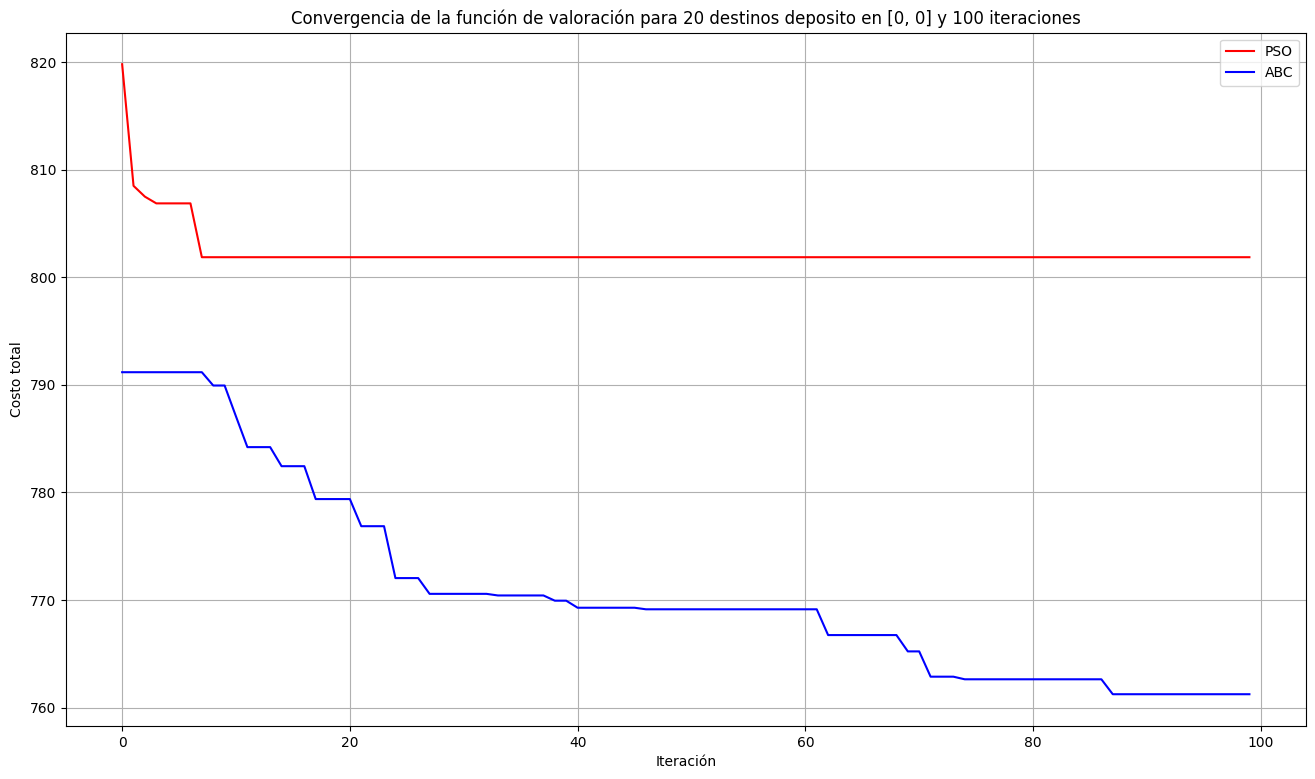

Tiempo de ejecucion para PSO: 0.14839895900149713 segundos
Costo para PSO: 801.8674566246274 segundos


In [249]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_20_dep0_l100[0][1], "PSO", "red",20,[0,0],100)
plot_convergence(ABC_20_dep0_l100[0][1], "ABC", "blue",20,[0,0],100)
plt.show()
print(f"Tiempo de ejecucion para PSO: {PSO_20_dep0_l100[0][0][1]} segundos")
print(f"Costo para PSO: {PSO_20_dep0_l100[0][0][0]} segundos")

### 20 destinos, depósito en [0, 0] y 500 iteraciones

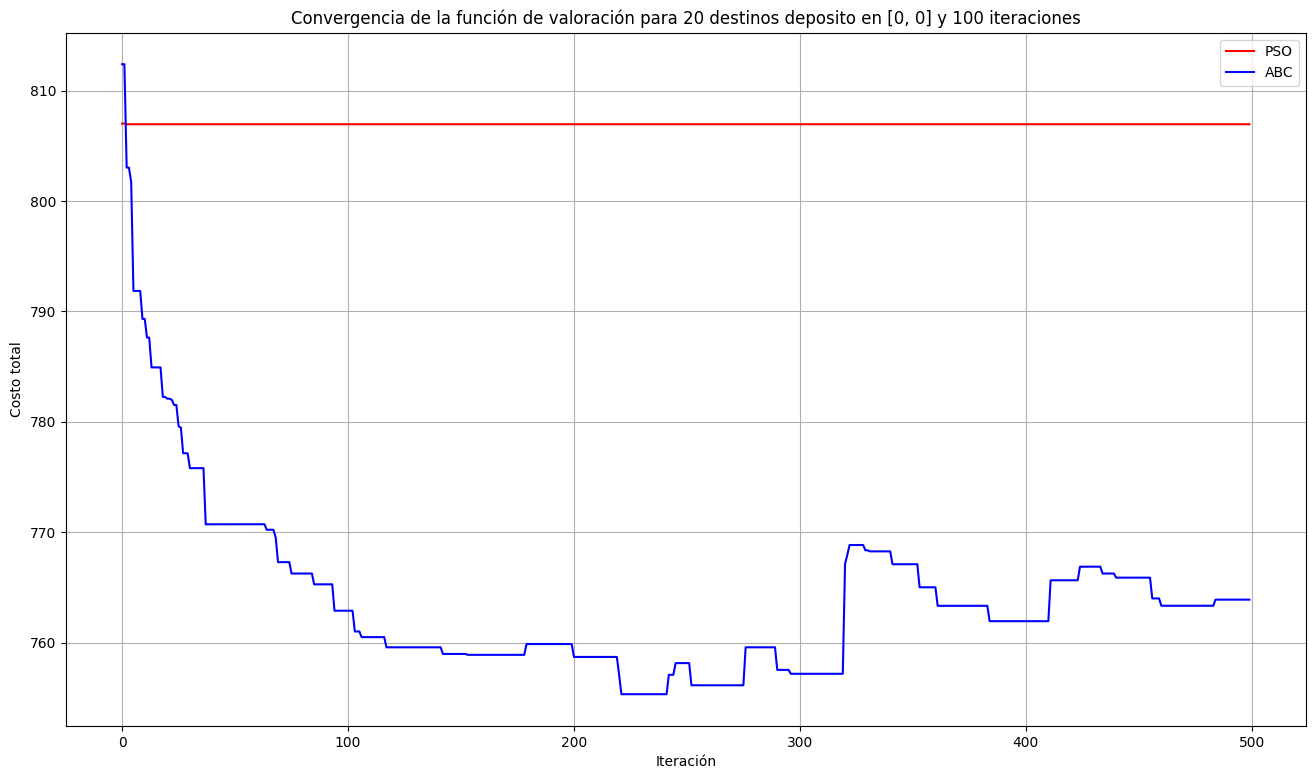

In [250]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_20_dep0_l500[0][1], "PSO", "red",20,[0,0],100)
plot_convergence(ABC_20_dep0_l500[0][1], "ABC", "blue",20,[0,0],100)
plt.show()

### 20 destinos, depósito en [5, 5] y 100 iteraciones

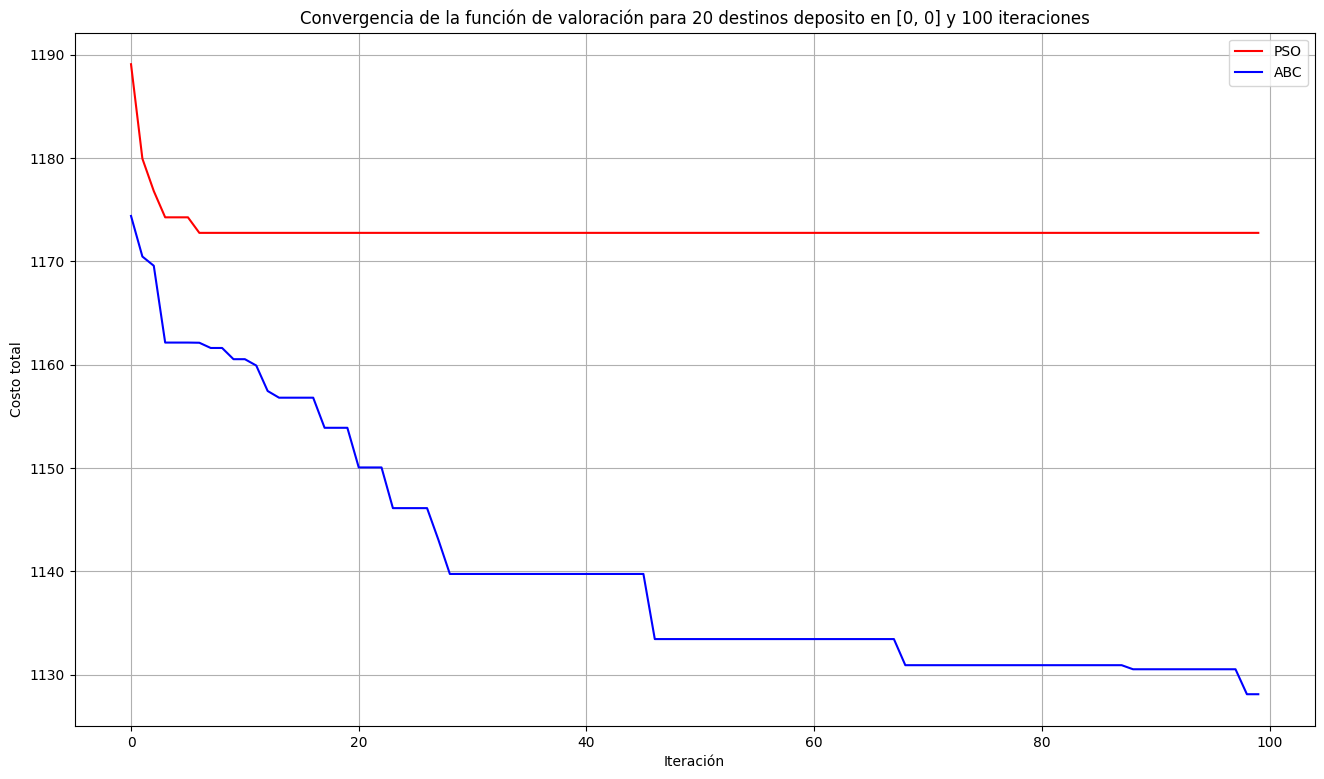

In [251]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_20_dep5_l100[0][1], "PSO", "red",20,[5,5],100)
plot_convergence(ABC_20_dep5_l100[0][1], "ABC", "blue",20,[0,0],100)
plt.show()

### 20 destinos, depósito en [5, 5] y 500 iteraciones

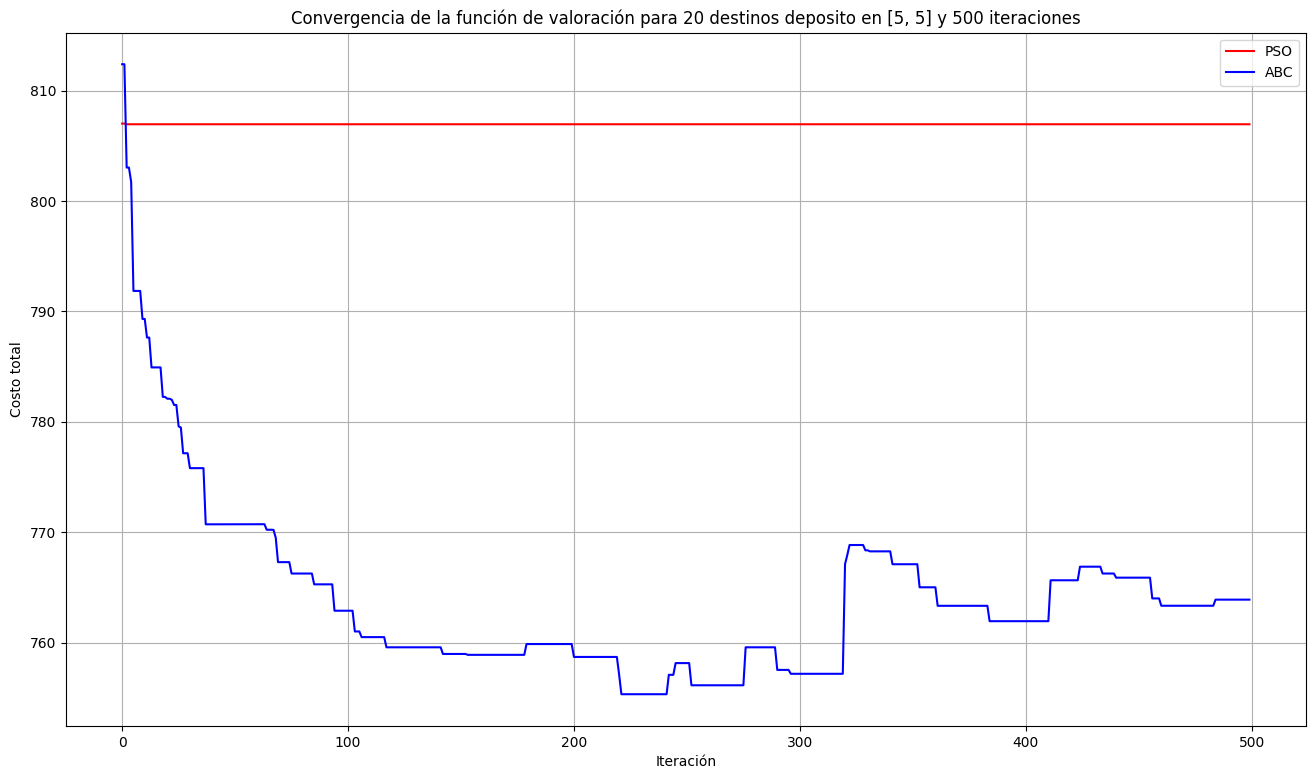

In [252]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_20_dep0_l500[0][1], "PSO", "red",20,[5,5],500)
plot_convergence(ABC_20_dep0_l500[0][1], "ABC", "blue",20,[5,5],500)
plt.show()

### 50 destinos, depósito en [0, 0] y 100 iteraciones

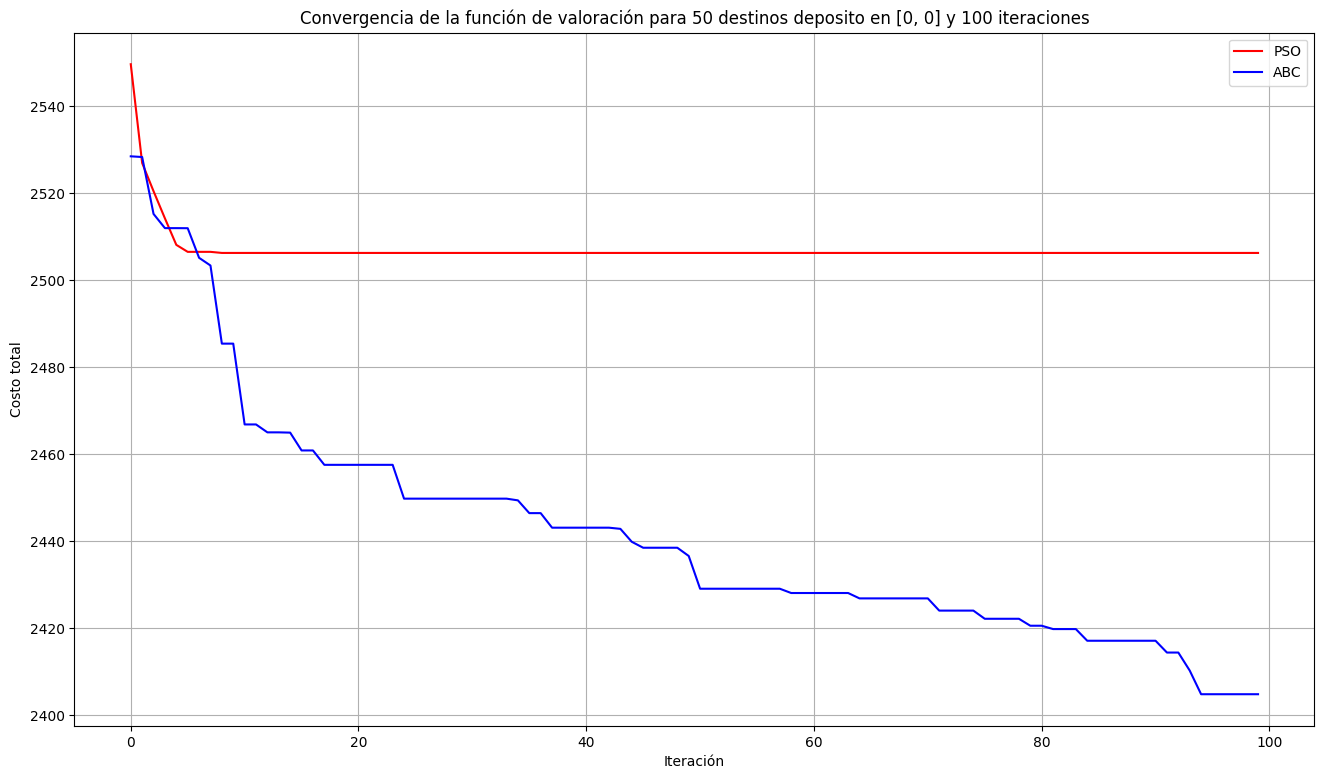

In [253]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_50_dep0_l100[0][1], "PSO", "red",50,[0,0],100)
plot_convergence(ABC_50_dep0_l100[0][1], "ABC", "blue",50,[0,0],100)
plt.show()

### 50 destinos, depósito en [0, 0] y 500 iteraciones

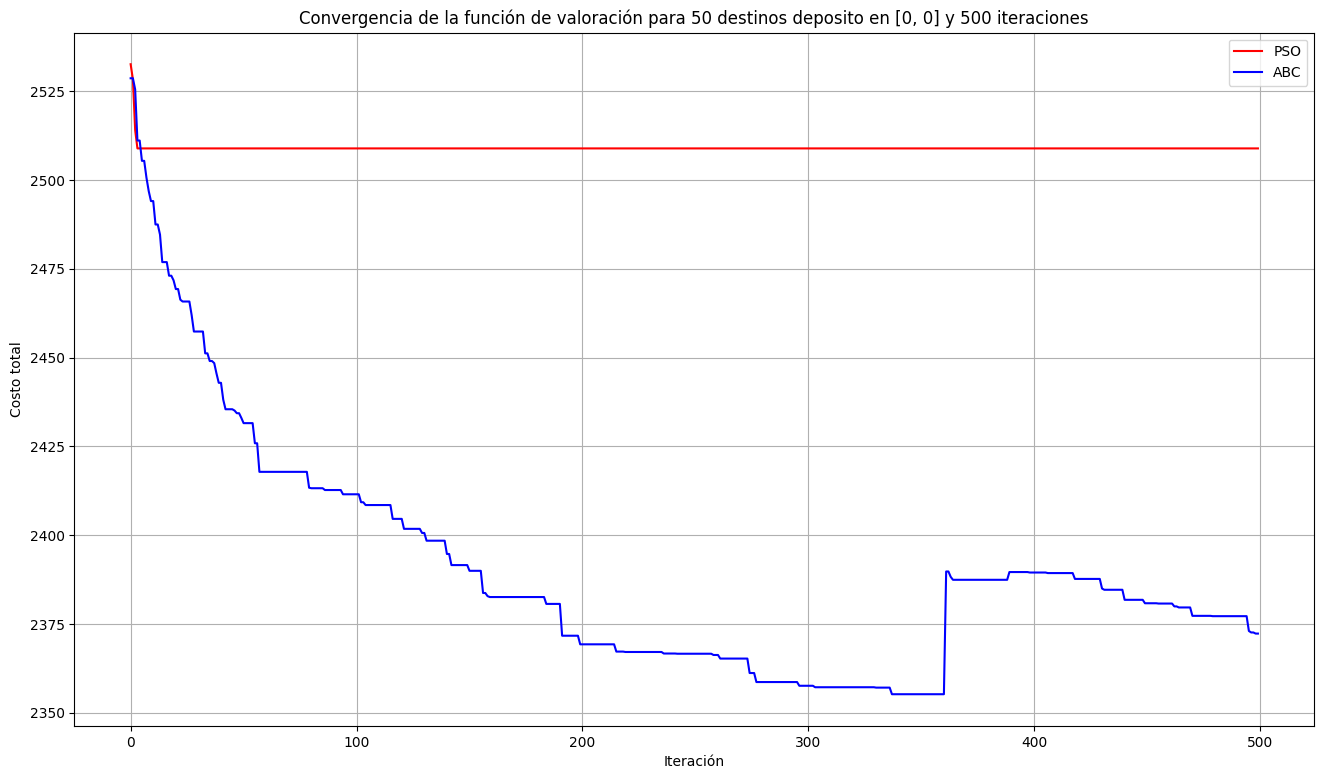

In [254]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_50_dep0_l500[0][1], "PSO", "red",50,[0,0],500)
plot_convergence(ABC_50_dep0_l500[0][1], "ABC", "blue",50,[0,0],500)
plt.show()

### 50 destinos, depósito en [5, 5] y 100 iteraciones

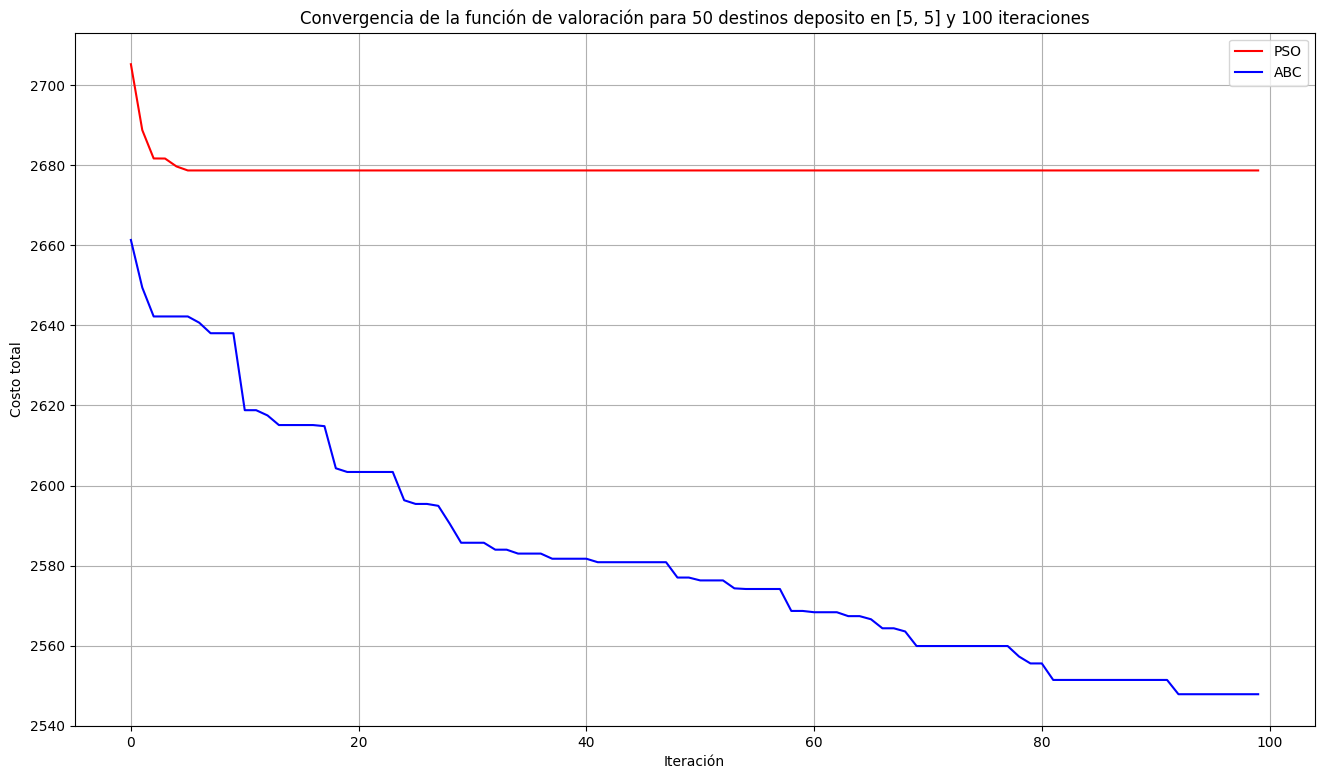

In [255]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_50_dep5_l100[0][1], "PSO", "red",50,[5,5],100)
plot_convergence(ABC_50_dep5_l100[0][1], "ABC", "blue",50,[5,5],100)
plt.show()

### 50 destinos, depósito en [5, 5] y 500 iteraciones

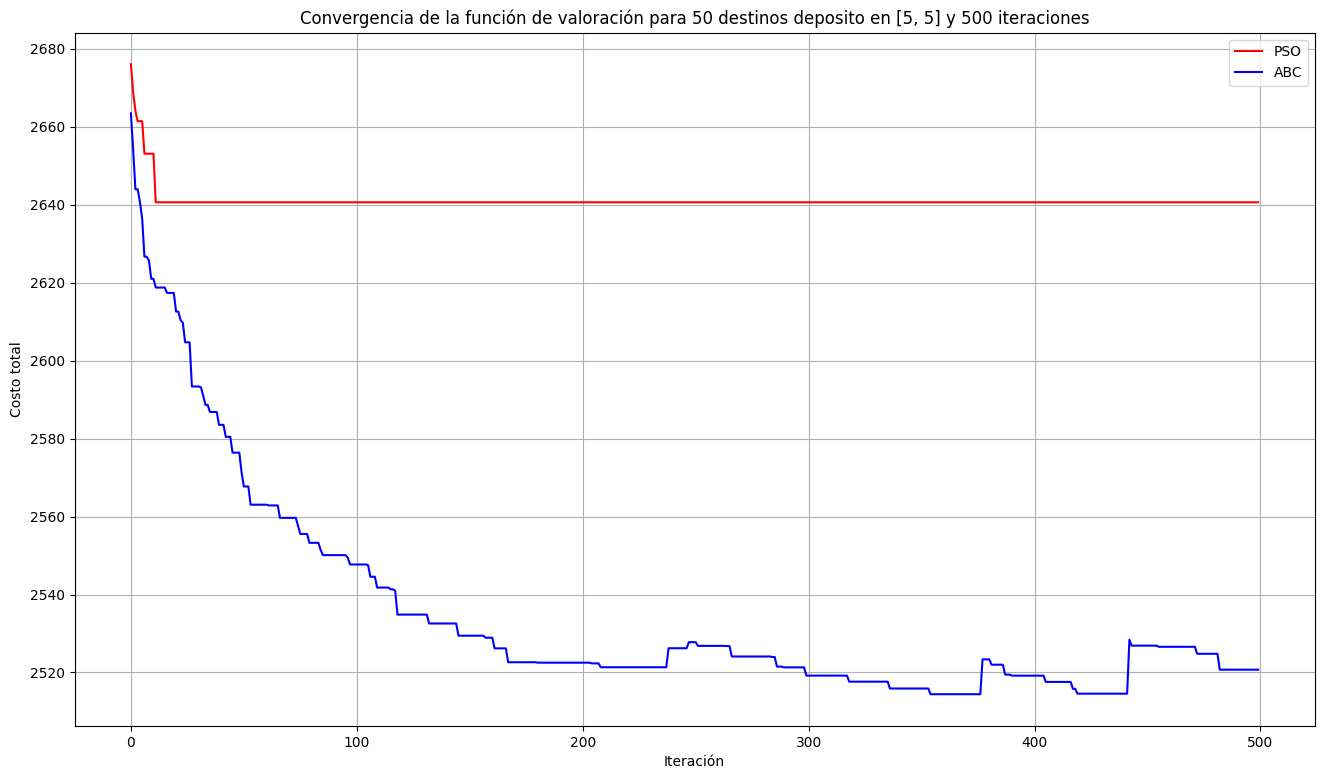

In [256]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_50_dep5_l500[0][1], "PSO", "red",50,[5,5],500)
plot_convergence(ABC_50_dep5_l500[0][1], "ABC", "blue",50,[5,5],500)
plt.show()

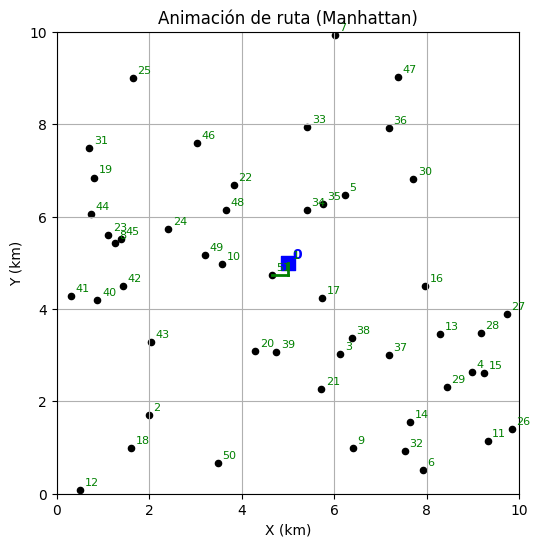

In [257]:
anim = make_animation(coords_map, ruta_pso, deposito=[5,5], pause=500)# Animacion PSO
HTML(anim.to_jshtml())

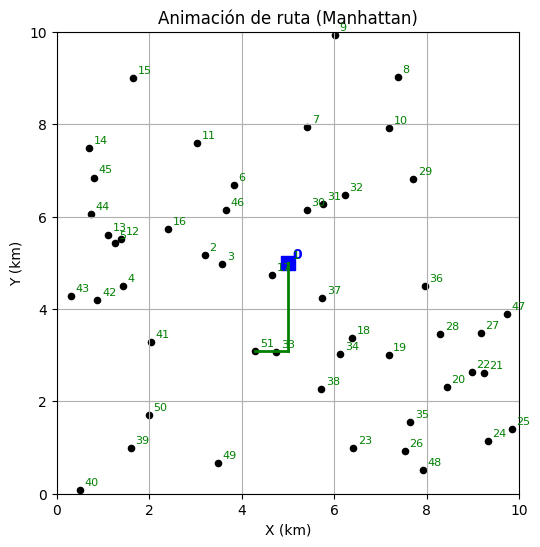

In [258]:
anim2 = make_animation(coords_map, ruta_abc, deposito=[5,5], pause=500)
HTML(anim2.to_jshtml())